# Random quadratic programming.

Here, we are going to try to simulate the Macarthur Resource Consumer dynamics, specifically

$$
\begin{align}
\frac{d \lambda_i}{dt} &= \lambda_i (\sum_{\alpha} c_{i,\alpha} R_{\alpha} - m_i) \\
\frac{d R_{\alpha}}{dt} &= R_{\alpha} (K_{\alpha} - R_{\alpha} - \sum_j \lambda_j c_{j, \alpha} R_{\alpha})
\end{align}
$$

There are 3 different parameters that we will want to simulation, namely $c$, $m$ and $K$

We will also want to randomly generate the initial conditions of all of the species and resources.  
The lognormal distribution will be our default generating distribution.

In [1]:
import numpy as np
from cvxopt import matrix
from cvxopt import solvers
np.random.seed(0)

n_species = 100
n_resources = 500

c = np.random.lognormal(size=(n_species, n_resources))
K = np.random.lognormal(size=(n_resources))
m = np.random.lognormal(size=(n_species))
N0 = np.random.lognormal(size=(n_species))
R0 = np.random.lognormal(size=(n_resources))

In [2]:
# Define QP parameters (directly)
M = np.identity(n_resources)
P = np.dot(M.T, M)
q = -np.dot(K, M).reshape((n_resources,))
G1= c
h1= m

G2 = -np.identity(n_resources)
h2 = np.zeros(n_resources)
G=np.concatenate((G1, G2), axis=0)
h=np.concatenate((h1, h2), axis=None)

In [3]:
P = matrix(P,tc="d")
q = matrix(q, tc="d")
G = matrix(G, tc="d")
h = matrix(h, tc="d")

solvers.options['show_progress'] = False
solvers.options['abstol']=1e-8
solvers.options['reltol']=1e-8
solvers.options['feastol']=1e-8
solvers.options['DSDP_Monitor'] = 1
sol = solvers.qp(P,q,G,h)

In [4]:
import matplotlib.pyplot as plt
plt.plot(sorted(np.array(sol['x']).ravel())[::-1])
plt.yscale('log')

In [5]:
sol

{'x': <500x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <600x1 matrix, tc='d'>,
 'z': <600x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 7.775937690048025e-10,
 'relative gap': 5.509565072682828e-10,
 'primal objective': -1.4113523640191095,
 'dual objective': -1.411352364742492,
 'primal infeasibility': 8.653390659187969e-15,
 'dual infeasibility': 9.385113155618613e-13,
 'primal slack': 7.682801078008646e-15,
 'dual slack': 2.1248318916450688e-13,
 'iterations': 18}

Here, we will simulate resource capacities.  We will model resource capacities $K_{\alpha}$ in two different environments using a logistic normal.  

Specifically, we will model the class probabilities (i.e. the probability of being in environment 1 or 2). 
Then from those probabilities, we will generate resource capacities per sample.

In [6]:
reps = 175 # samples per group
num_samples = reps * 2
effect_size = 1
k = 2
sigma = 1 
r_mean = 0  # will need to think about this
r_var = 0.1   # will need to think about this

labels = np.array([-effect_size] * (reps) + [effect_size] * (reps))
eps = np.random.logistic(loc=0, scale=sigma, size=num_samples)
class_probs = labels + eps

X = np.hstack((np.ones((num_samples, 1)), class_probs.reshape(-1, 1)))

# regression coefficients
B = np.random.normal(loc=r_mean, scale=r_var, size=(k, n_resources))

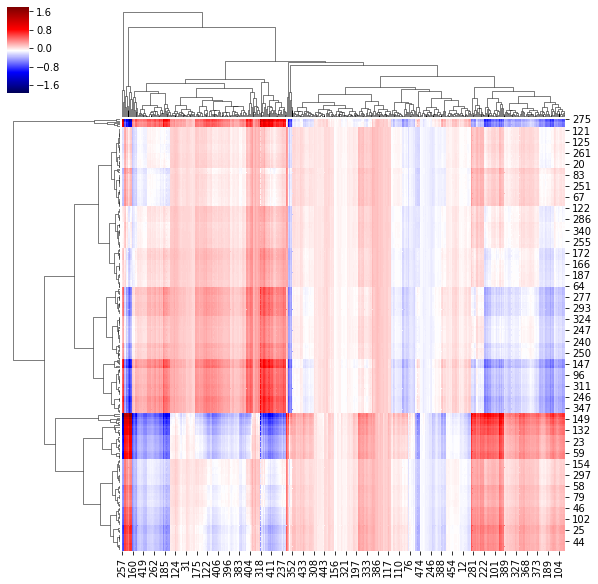

In [7]:
import seaborn as sns

sns.clustermap(X @ B, cmap='seismic')

In [8]:
microbes = []
resources = []
Ks = np.exp(X @ B)

for s in range(num_samples):

    K = Ks[s, :]
    
    # Define QP parameters (directly)
    M = np.identity(n_resources)
    P = np.dot(M.T, M)
    q = -np.dot(K, M).reshape((n_resources,))
    G1= c
    h1= m

    G2 = -np.identity(n_resources)
    h2 = np.zeros(n_resources)
    G=np.concatenate((G1, G2), axis=0)
    h=np.concatenate((h1, h2), axis=None)   
    
    P = matrix(P,tc="d")
    q = matrix(q, tc="d")
    G = matrix(G, tc="d")
    h = matrix(h, tc="d")    
    sol = solvers.qp(P,q,G,h)
    resources.append(np.ravel(sol['x']))
    microbes.append(np.ravel(sol['z'])[:n_species])

In [9]:
microbes = np.vstack(microbes)
resources = np.vstack(resources)

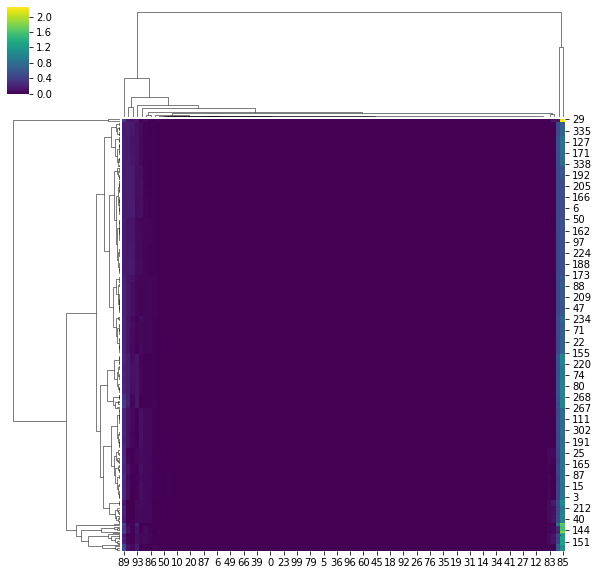

In [10]:
sns.clustermap(microbes, cmap='viridis')

In [14]:
idx = np.log(microbes.sum(axis=0)) > -1

In [15]:
microbes = microbes[:, idx]

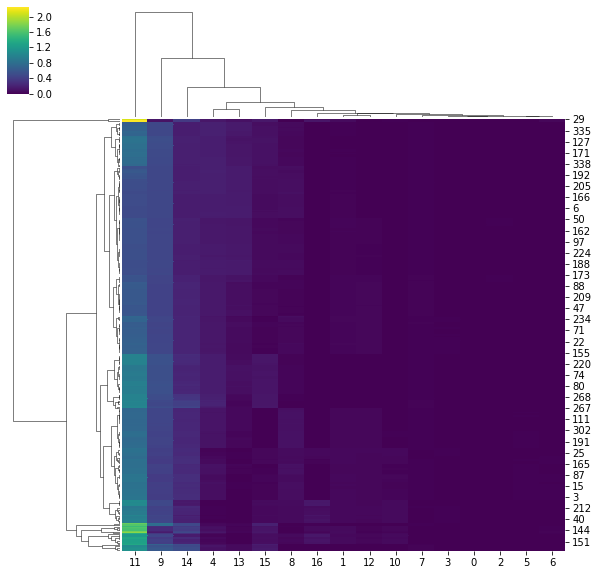

In [16]:
sns.clustermap(microbes, cmap='viridis')